Zipline beginner tutorial
=========================

Basics
------

Zipline is an open-source algorithmic trading simulator written in Python.

The source can be found at: https://github.com/quantopian/zipline

Some benefits include:

* Realistic: slippage, transaction costs, order delays.
* Stream-based: Process each event individually, avoids look-ahead bias.
* Batteries included: Common transforms (moving average) as well as common risk calculations (Sharpe).
* Developed and continuously updated by [Quantopian](https://www.quantopian.com) which provides an easy-to-use web-interface to Zipline, 10 years of minute-resolution historical US stock data, and live-trading capabilities. This tutorial is directed at users wishing to use Zipline without using Quantopian. If you instead want to get started on Quantopian, see [here](https://www.quantopian.com/faq#get-started).

This tutorial assumes that you have zipline correctly installed, see the [installation instructions](https://github.com/quantopian/zipline#installation) if you haven't set up zipline yet.

Every `zipline` algorithm consists of two functions you have to define:
* `initialize(context)`
* `handle_data(context, data)`

Before the start of the algorithm, `zipline` calls the `initialize()` function and passes in a `context` variable. `context` is a persistent namespace for you to store variables you need to access from one algorithm iteration to the next.

After the algorithm has been initialized, `zipline` calls the `handle_data()` function once for each event. At every call, it passes the same `context` variable and an event-frame called `data` containing the current trading bar with open, high, low, and close (OHLC) prices as well as volume for each stock in your universe. For more information on these functions, see the [relevant part of the Quantopian docs](https://www.quantopian.com/help#api-toplevel).

My first algorithm
----------------------

Lets take a look at a very simple algorithm from the `examples` directory, `buyapple.py`:

In [1]:
!tail ../../zipline/examples/buyapple.py

    # Load price data from yahoo.
    data = load_from_yahoo(stocks=['AAPL'], indexes={}, start=start,
                           end=end)

    # Create and run the algorithm.
    algo = TradingAlgorithm(initialize=initialize, handle_data=handle_data,
                            identifiers=['AAPL'])
    results = algo.run(data)

    analyze(results=results)


As you can see, we first have to import some functions we would like to use. All functions commonly used in your algorithm can be found in `zipline.api`. Here we are using `order()` which takes two arguments -- a security object, and a number specifying how many stocks you would like to order (if negative, `order()` will sell/short stocks). In this case we want to order 10 shares of Apple at each iteration. For more documentation on `order()`, see the [Quantopian docs](https://www.quantopian.com/help#api-order).

Finally, the `record()` function allows you to save the value of a variable at each iteration. You provide it with a name for the variable together with the variable itself: `varname=var`. After the algorithm finished running you will have access to each variable value you tracked with `record()` under the name you provided (we will see this further below). You also see how we can access the current price data of the AAPL stock in the `data` event frame (for more information see [here](https://www.quantopian.com/help#api-event-properties).

## Running the algorithm

To now test this algorithm on financial data, `zipline` provides two interfaces. A command-line interface and an `IPython Notebook` interface.

### Command line interface
After you installed zipline you should be able to execute the following from your command line (e.g. `cmd.exe` on Windows, or the Terminal app on OSX):

In [2]:
!zipline run --help

Usage: zipline run [OPTIONS]

  Run a backtest for the given algorithm.

Options:
  -f, --algofile FILENAME         The file that contains the algorithm to run.
  -t, --algotext TEXT             The algorithm script to run.
  -D, --define TEXT               Define a name to be bound in the namespace
                                  before executing the algotext. For example
                                  '-Dname=value'. The value may be any python
                                  expression. These are evaluated in order so
                                  they may refer to previously defined names.
  --data-frequency [daily|minute]
                                  The data frequency of the simulation.
                                  [default: daily]
  --capital-base FLOAT            The starting capital for the simulation.
                                  [default: 10000000.0]
  -b, --bundle BUNDLE-NAME        The data bundle to use for the simulation.
                       

Note that you have to omit the preceding '!' when you call `run_algo.py`, this is only required by the IPython Notebook in which this tutorial was written.

As you can see there are a couple of flags that specify where to find your algorithm (`-f`) as well as parameters specifying which stock data to load from Yahoo! finance and the time-range (`--start` and `--end`). Finally, you'll want to save the performance metrics of your algorithm so that you can analyze how it performed. This is done via the `--output` flag and will cause it to write the performance `DataFrame` in the pickle Python file format. Note that you can also define a configuration file with these parameters that you can then conveniently pass to the `-c` option so that you don't have to supply the command line args all the time (see the .conf files in the examples directory).

Thus, to execute our algorithm from above and save the results to `buyapple_out.pickle` we would call `run_algo.py` as follows:

In [3]:
!zipline run -f ../../zipline/examples/buyapple.py --start 2000-1-1 --end 2014-1-1 -o buyapple_out.pickle

AAPL
[2015-11-04 22:45:32.820166] INFO: Performance: Simulated 3521 trading days out of 3521.
[2015-11-04 22:45:32.820314] INFO: Performance: first open: 2000-01-03 14:31:00+00:00
[2015-11-04 22:45:32.820401] INFO: Performance: last close: 2013-12-31 21:00:00+00:00


`run_algo.py` first outputs the algorithm contents. It then fetches historical price and volume data of Apple from Yahoo! finance in the desired time range, calls the `initialize()` function, and then streams the historical stock price day-by-day through `handle_data()`. After each call to `handle_data()` we instruct `zipline` to order 10 stocks of AAPL. After the call of the `order()` function, `zipline` enters the ordered stock and amount in the order book. After the `handle_data()` function has finished, `zipline` looks for any open orders and tries to fill them. If the trading volume is high enough for this stock, the order is executed after adding the commission and applying the slippage model which models the influence of your order on the stock price, so your algorithm will be charged more than just the stock price * 10. (Note, that you can also change the commission and slippage model that `zipline` uses, see the [Quantopian docs](https://www.quantopian.com/help#ide-slippage) for more information).

Note that there is also an `analyze()` function printed. `run_algo.py` will try and look for a file with the ending with `_analyze.py` and the same name of the algorithm (so `buyapple_analyze.py`) or an `analyze()` function directly in the script. If an `analyze()` function is found it will be called *after* the simulation has finished and passed in the performance `DataFrame`. (The reason for allowing specification of an `analyze()` function in a separate file is that this way `buyapple.py` remains a valid Quantopian algorithm that you can copy&paste to the platform).

Lets take a quick look at the performance `DataFrame`. For this, we use `pandas` from inside the IPython Notebook and print the first ten rows. Note that `zipline` makes heavy usage of `pandas`, especially for data input and outputting so it's worth spending some time to learn it.

In [4]:
import pandas as pd
perf = pd.read_pickle('buyapple_out.pickle') # read in perf DataFrame
print perf.head()

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2000-01-03 21:00:00,3.738314,0.000000e+00,0.000000e+00,-0.065800,-0.009549,0.000000,0.000000,0.00000,10000000.00000,0.00000,...,0,0,0,0.000000,10000000.00000,0.00000,0.00000,1,[],0.0658
2000-01-04 21:00:00,3.423135,3.367492e-07,-3.000000e-08,-0.064897,-0.047528,0.323229,0.000001,-34.53135,9999965.46865,34.23135,...,0,0,0,0.000000,10000000.00000,0.00000,0.00000,2,[{u'order_id': u'513357725cb64a539e3dd02b47da7...,0.0649
2000-01-05 21:00:00,3.473229,4.001918e-07,-9.906000e-09,-0.066196,-0.045697,0.329321,0.000001,-35.03229,9999930.43636,69.46458,...,0,0,0,0.000000,9999965.46865,34.23135,34.23135,3,[{u'order_id': u'd7d4ad03cfec4d578c0d817dc3829...,0.0662
2000-01-06 21:00:00,3.172661,4.993979e-06,-6.410420e-07,-0.065758,-0.044785,0.298325,-0.000006,-32.02661,9999898.40975,95.17983,...,0,0,0,-12731.780516,9999930.43636,69.46458,69.46458,4,[{u'order_id': u'1fbf5e9bfd7c4d9cb2e8383e1085e...,0.0657
2000-01-07 21:00:00,3.322945,5.977002e-06,-2.201900e-07,-0.065206,-0.018908,0.375301,0.000005,-33.52945,9999864.88030,132.91780,...,0,0,0,-12629.274583,9999898.40975,95.17983,95.17983,5,[{u'order_id': u'9ea6b142ff09466b9113331a37437...,0.0652


As you can see, there is a row for each trading day, starting on the first business day of 2000. In the columns you can find various information about the state of your algorithm. The very first column `AAPL` was placed there by the `record()` function mentioned earlier and allows us to plot the price of apple. For example, we could easily examine now how our portfolio value changed over time compared to the AAPL stock price.

Populating the interactive namespace from numpy and matplotlib


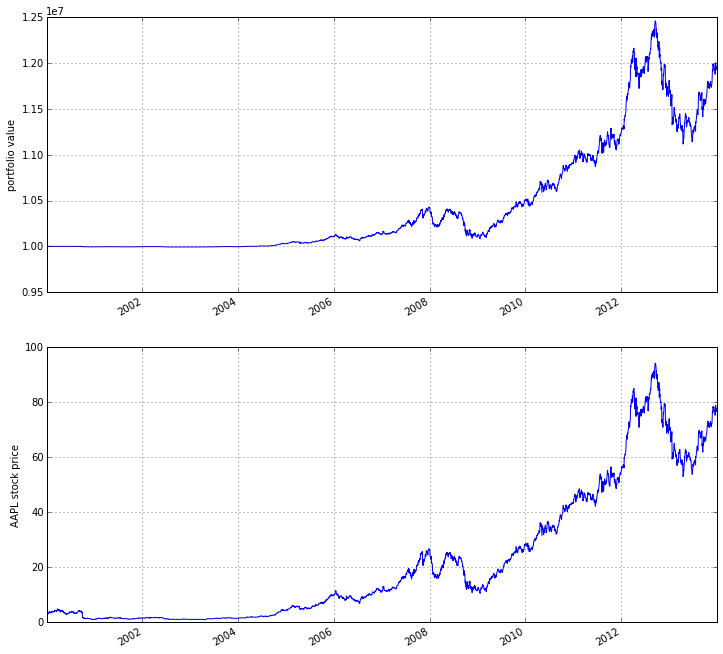

In [5]:
%pylab inline
figsize(12, 12)
import matplotlib.pyplot as plt

ax1 = plt.subplot(211)
perf.portfolio_value.plot(ax=ax1)
ax1.set_ylabel('portfolio value')
ax2 = plt.subplot(212, sharex=ax1)
perf.AAPL.plot(ax=ax2)
ax2.set_ylabel('AAPL stock price')

As you can see, our algorithm performance as assessed by the `portfolio_value` closely matches that of the AAPL stock price. This is not surprising as our algorithm only bought AAPL every chance it got.

### IPython Notebook

The [IPython Notebook](http://ipython.org/notebook.html) is a very powerful browser-based interface to a Python interpreter (this tutorial was written in it). As it is already the de-facto interface for most quantitative researchers `zipline` provides an easy way to run your algorithm inside the Notebook without requiring you to use the CLI. 

To use it you have to write your algorithm in a cell and let `zipline` know that it is supposed to run this algorithm. This is done via the `%%zipline` IPython magic command that is available after you `import zipline` from within the IPython Notebook. This magic takes the same arguments as the command line interface described above. Thus to run the algorithm from above with the same parameters we just have to execute the following cell after importing `zipline` to register the magic.

In [6]:
import zipline

In [7]:
%%zipline --start 2000-1-1 --end 2014-1-1 -o perf_ipython

from zipline.api import symbol, order, record

def initialize(context):
    pass

def handle_data(context, data):
    order(symbol('AAPL'), 10)
    record(AAPL=data[symbol('AAPL')].price)

AAPL


Note that we did not have to specify an input file as above since the magic will use the contents of the cell and look for your algorithm functions there. Also, instead of defining an output file we are specifying a variable name with `-o` that will be created in the name space and contain the performance `DataFrame` we looked at above.

In [8]:
perf_ipython.head()

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2000-01-03 21:00:00,3.738314,0.000000e+00,0.000000e+00,-0.065800,-0.009549,0.000000,0.000000,0.00000,10000000.00000,0.00000,...,0,0,0,0.000000,10000000.00000,0.00000,0.00000,1,[],0.0658
2000-01-04 21:00:00,3.423135,3.367492e-07,-3.000000e-08,-0.064897,-0.047528,0.323229,0.000001,-34.53135,9999965.46865,34.23135,...,0,0,0,0.000000,10000000.00000,0.00000,0.00000,2,"[{u'commission': 0.3, u'amount': 10, u'sid': 0...",0.0649
2000-01-05 21:00:00,3.473229,4.001918e-07,-9.906000e-09,-0.066196,-0.045697,0.329321,0.000001,-35.03229,9999930.43636,69.46458,...,0,0,0,0.000000,9999965.46865,34.23135,34.23135,3,"[{u'commission': 0.3, u'amount': 10, u'sid': 0...",0.0662
2000-01-06 21:00:00,3.172661,4.993979e-06,-6.410420e-07,-0.065758,-0.044785,0.298325,-0.000006,-32.02661,9999898.40975,95.17983,...,0,0,0,-12731.780516,9999930.43636,69.46458,69.46458,4,"[{u'commission': 0.3, u'amount': 10, u'sid': 0...",0.0657
2000-01-07 21:00:00,3.322945,5.977002e-06,-2.201900e-07,-0.065206,-0.018908,0.375301,0.000005,-33.52945,9999864.88030,132.91780,...,0,0,0,-12629.274583,9999898.40975,95.17983,95.17983,5,"[{u'commission': 0.3, u'amount': 10, u'sid': 0...",0.0652


### Manual (advanced)

If you are happy with either way above you can safely skip this passage. To provide a closer look at how `zipline` actually works it is instructive to see how we run an algorithm without any of the interfaces demonstrated above which hide the actual `zipline` API.

In [9]:
import pytz
from datetime import datetime

from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_bars_from_yahoo

# Load data manually from Yahoo! finance
start = datetime(2000, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2012, 1, 1, 0, 0, 0, 0, pytz.utc)
data = load_bars_from_yahoo(stocks=['AAPL'], start=start,
                            end=end)

# Define algorithm
def initialize(context):
    pass

def handle_data(context, data):
    order(symbol('AAPL'), 10)
    record(AAPL=data[symbol('AAPL')].price)

# Create algorithm object passing in initialize and
# handle_data functions
algo_obj = TradingAlgorithm(initialize=initialize, 
                            handle_data=handle_data)

# Run algorithm
perf_manual = algo_obj.run(data)

AAPL


As you can see, we again define the functions as above but we manually pass them to the `TradingAlgorithm` class which is the main `zipline` class for running algorithms. We also manually load the data using `load_bars_from_yahoo()` and pass it to the `TradingAlgorithm.run()` method which kicks off the backtest simulation.

##Access to previous prices using `history`

###Working example: Dual Moving Average Cross-Over

The Dual Moving Average (DMA) is a classic momentum strategy. It's probably not used by any serious trader anymore but is still very instructive. The basic idea is that we compute two rolling or moving averages (mavg) -- one with a longer window that is supposed to capture long-term trends and one shorter window that is supposed to capture short-term trends. Once the short-mavg crosses the long-mavg from below we assume that the stock price has upwards momentum and long the stock. If the short-mavg crosses from above we exit the positions as we assume the stock to go down further.

As we need to have access to previous prices to implement this strategy we need a new concept: History

`history()` is a convenience function that keeps a rolling window of data for you. The first argument is the number of bars you want to collect, the second argument is the unit (either `'1d'` for `'1m'` but note that you need to have minute-level data for using `1m`). For a more detailed description `history()`'s features, see the [Quantopian docs](https://www.quantopian.com/help#ide-history). Let's look at the strategy which should make this clear:

AAPL


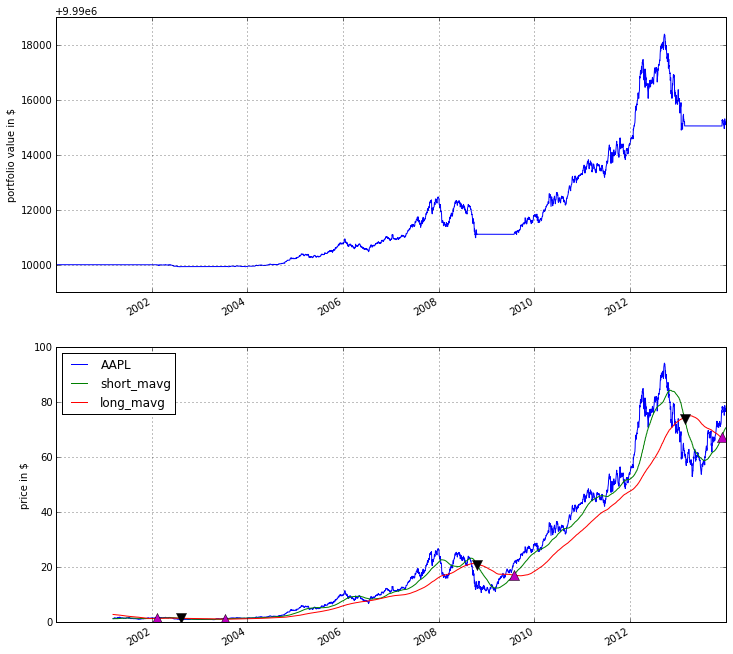

In [10]:
%%zipline --start 2000-1-1 --end 2014-1-1 -o perf_dma


from zipline.api import order_target, record, symbol, history
import numpy as np

def initialize(context):
    context.i = 0


def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return

    # Compute averages
    # history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = history(100, '1d', 'price').mean()
    long_mavg = history(300, '1d', 'price').mean()

    # Trading logic
    if short_mavg[0] > long_mavg[0]:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(symbol('AAPL'), 100)
    elif short_mavg[0] < long_mavg[0]:
        order_target(symbol('AAPL'), 0)

    # Save values for later inspection
    record(AAPL=data[symbol('AAPL')].price,
           short_mavg=short_mavg[0],
           long_mavg=long_mavg[0])
    
    
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
    perf['AAPL'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.ix[[t != [] for t in perf.transactions]]
    buys = perf_trans.ix[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.ix[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.short_mavg.ix[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.short_mavg.ix[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    plt.show()

Here we are explicitly defining an `analyze()` function that gets automatically called once the backtest is done (this is not possible on Quantopian currently).

Although it might not be directly apparent, the power of `history()` (pun intended) can not be under-estimated as most algorithms make use of prior market developments in one form or another. You could easily devise a strategy that trains a classifier with [`scikit-learn`](http://scikit-learn.org/stable/) which tries to predict future market movements based on past prices (note, that most of the `scikit-learn` functions require `numpy.ndarray`s rather than `pandas.DataFrame`s, so you can simply pass the underlying `ndarray` of a `DataFrame` via `.values`).

We also used the `order_target()` function above. This and other functions like it can make order management and portfolio rebalancing much easier. See the [Quantopian documentation on order functions](https://www.quantopian.com/help#api-order-methods) fore more details.

# Conclusions

We hope that this tutorial gave you a little insight into the architecture, API, and features of `zipline`. For next steps, check out some of the [examples](https://github.com/quantopian/zipline/tree/master/zipline/examples).

Feel free to ask questions on [our mailing list](https://groups.google.com/forum/#!forum/zipline), report problems on our [GitHub issue tracker](https://github.com/quantopian/zipline/issues?state=open), [get involved](https://github.com/quantopian/zipline/wiki/Contribution-Requests), and [checkout Quantopian](https://quantopian.com).